# ***LENDING CLUB- INVESTMENT STRATEGY***

--*Summary of key findings*:

This notebook aids in analyzing LendingClub's loan data to uncover patterns in borrower behavior and risk, with the goal of informing investment decisions for Jasmine. The key findings include:

* **Return-based loan evaluation**: The notebook introduces three return calculation methods (optimistic, pessimistic, and intermediate), showing variation in performance based on assumptions of default and recovery.  
*   **Effective borrower segmentation**: Using K-Means clustering on standardized numerical borrower features, the notebook identifies distinct borrower groups with unique risk-return profiles.
*   **Loan grade alignment**: The clustering results strongly align with LendingClub’s internal grading system, validating the segmentation and supporting its use in investment decision-making.
*   **Parallel coordinates and PCA visualizations**: These plots help clearly interpret cluster profiles and show how clusters differ across key financial dimensions like income, DTI, and utilization.

--*Logical flow and structure of the notebook*:

  1. Data Ingestion: LendingClub CSVs for 2014 data is imported, cleaned, and stored.

  2. Feature Selection & Typing: Columns are chosen to reflect only the information available at the time of loan issuance. This decision avoids data leakage and improves model reliability.

  3. Return Computation: Three return metrics are calculated to handle uncertainty in outcomes (best case, worst case, average case)

  4. Data Cleaning: Outliers in features like revol_util and annual_inc are removed using boxplot analysis to improve clustering performance.

  5. Clustering: K-Means is chosen for its interpretability and scalability. Features are standardized and evaluated with PCA and the Elbow method to identify the optimal number of clusters.

  6. Cluster Interpretation: Each cluster is labeled using parallel coordinates plots, and cluster-to-grade heatmaps validate the segmentation quality.



## Data Ingestion

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 ## Download

In [9]:
#You can download the archived data for 2014 from the WayBack machine here:
# https://web.archive.org/web/20220618001912/https://resources.lendingclub.com/LoanStats3c.csv.zip
# For the 2015 data, use
# https://web.archive.org/web/20230522033024/https://resources.lendingclub.com/LoanStats3d.csv.zip
# Download both zip files and unzip them.
# Put both these unzipped files in the appropriate folder ("../data" below) before proceeding below.
# The data dictionary is here: https://web.archive.org/web/20200606105339/https://resources.lendingclub.com/LCDataDictionary.xlsx}
dir_data= "/content/drive/MyDrive/Business Analytics"

 ## Ingestion


In [10]:
from typing import Dict, final
def ingest_files(directory: str) -> Dict:
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped.

    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.

    Note that each file will be read *without* formatting
    '''


    if directory[-1] != "/":
        directory = directory + "/"

    all_files = os.listdir(directory)
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:

        if i.find('.csv')<0:
            continue

        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1, quotechar='\"', engine='python')


    return output


In [12]:
# Ingest
files_data = ingest_files(dir_data)

Directory /content/drive/MyDrive/Business Analytics/ has 1 files:
    Reading file LoanStats3c.csv


In [13]:
files_data.keys()

dict_keys(['LoanStats3c.csv'])

In [14]:
data_now = pd.concat(files_data.values()).reset_index(drop = True)
columns = list(data_now.columns)
columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

 ## Choose Columns and Prepare Dataset

Overview of the dataset:

The LendingClub dataset includes different types of information about loans and the people who took them. It has details about the loan itself, like how much was borrowed and the interest rate. It also includes information about the borrower, such as their income, job history, and whether they own a home. There are features about their credit history, like how much debt they already have or if they’ve missed payments before. Some columns show how the loan was paid back, but those are only known after the loan is given. All of this helps us understand risk and group borrowers based on their financial behavior.

Additional variables and reasoning:



*   *Installment*   helps us understand the monthly repayment burden, which can impact affordability and default risk
*   *sub_grade*   provides a more detailed view of LendingClub’s internal risk assessment than the broader grade, allowing for finer segmentation
*   *inq_last_6mths*   captures recent credit-seeking behavior; a higher number may signal financial strain or aggressive borrowing.
*   *mths_since_last_delinq*   reflects how recently a borrower was delinquent—more recent delinquencies suggest higher risk





In [15]:
# Columns we'll be keeping from the dataset
cols_to_pick = ['id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec',

                 'revol_bal','revol_util', 'total_pymnt',
                 'last_pymnt_d', 'recoveries', 'sub_grade', 'inq_last_6mths', 'mths_since_last_delinq']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                      'inq_last_6mths', 'mths_since_last_delinq',
                                'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose', 'sub_grade']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])


In [16]:
# Keep only the columns of interest
final_data = data_now[cols_to_pick].copy()


In [17]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 235631 rows


 ### Typecast the columns

In [18]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.rstrip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc)

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )

for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None


In [19]:
final_data.head()


id  loan_amnt  funded_amnt        term  int_rate  installment grade  \
0  NaN    15000.0      15000.0   60 months     12.39       336.64     C   
1  NaN    10400.0      10400.0   36 months      6.99       321.08     A   
2  NaN     7650.0       7650.0   36 months     13.66       260.20     C   
3  NaN    12800.0      12800.0   60 months     17.14       319.08     D   
4  NaN    21425.0      21425.0   60 months     15.59       516.36     D   

  emp_length home_ownership  annual_inc  ... open_acc pub_rec revol_bal  \
0  10+ years           RENT     78000.0  ...      6.0     0.0  138008.0   
1    8 years       MORTGAGE     58000.0  ...     17.0     0.0    6133.0   
2   < 1 year           RENT     50000.0  ...     11.0     0.0   16822.0   
3  10+ years       MORTGAGE    125000.0  ...      8.0     0.0    5753.0   
4    6 years           RENT     63800.0  ...     10.0     0.0   16374.0   

  revol_util   total_pymnt  last_pymnt_d recoveries  sub_grade  \
0       29.0  17392.370000    2016-06-01       0.00         C1   
1       31.6   6611.690000    2016-08-01     521.27         A3   
2       91.9   2281.980000    2015-08-01    1237.99         C3   
3      100.9  19165.351925    2019-09-01       0.00         D4   
4       76.2  25512.200000    2016-05-01       0.00         D1   

   inq_last_6mths  mths_since_last_delinq  
0             0.0                     NaN  
1             2.0                    42.0  
2             1.0                     NaN  
3             0.0                    17.0  
4             0.0                    60.0  

[5 rows x 27 columns]

In [20]:
# Deal with null values. We allow categorical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 116027 rows


In [21]:
final_data.shape

(119604, 27)

In [22]:
#Checking for unique values- to remove columns with only one value

remove_columns_list = []
for i in final_data.columns:
    # Check if unique value count is 1
    if final_data[i].nunique() == 1:
        remove_columns_list.append(i)


# Remove those columns
final_data.drop(remove_columns_list, axis = 1, inplace = True)
final_data.shape
#drops application_type

(119604, 27)

In [23]:
#Dropping columns where missing data is more than equal to 65%
for col in final_data.columns:
    missing_values = round(final_data[col].isna().sum() / final_data.shape[0], 2)
    if missing_values >= 0.65:
        final_data.drop(col, axis = 1, inplace = True)

final_data.shape
#drops id- might contribute to skewed data

(119604, 26)

In [26]:
pickle_file = "/content/drive/MyDrive/Business Analytics/"

## Derived loan return features

In [27]:
#Defining the names of the four returns we'll be calculating

ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

In [28]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'D')
final_data['loan_length'] = final_data['loan_length'] / 30.436875 # Divide by the average number of days in a month to get approximate loan length in months
n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 17 rows


#### Return Method 2 (pessimistic)

In [29]:
# Calculate the return using a simple annualized profit margin
# Pessimistic fefinition (method 2)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int)
final_data['ret_PESS'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['term_num'])

#### Return Method 1 (optimistic)

In [30]:
# Assuming that if a loan gives a positive return, we can immediately find a similar loan to invest in; if the loan takes a loss, we use method 2 to compute the return

final_data['ret_OPT'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['loan_length'])
final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.ret_PESS[final_data.ret_OPT < 0]

#### Return Method 3 (re-investment)

In [31]:
def ret_method_3(T, i):


    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )

    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries

    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )

final_data['ret_INTa'] = ret_method_3(5*12, 0.001)
final_data['ret_INTb'] = ret_method_3(5*12, 0.0025)
final_data['ret_INTc'] = ret_method_3(5*12, 0.005)

In [32]:
final_data.head()

loan_amnt  funded_amnt        term  int_rate  installment grade emp_length  \
1    10400.0      10400.0   36 months      6.99       321.08     A    8 years   
3    12800.0      12800.0   60 months     17.14       319.08     D  10+ years   
4    21425.0      21425.0   60 months     15.59       516.36     D    6 years   
6    12975.0      12975.0   36 months     17.86       468.17     D  10+ years   
7    16000.0      16000.0   60 months     11.44       351.40     B    6 years   

  home_ownership  annual_inc verification_status  ... sub_grade  \
1       MORTGAGE     58000.0        Not Verified  ...        A3   
3       MORTGAGE    125000.0            Verified  ...        D4   
4           RENT     63800.0     Source Verified  ...        D1   
6           RENT     60000.0     Source Verified  ...        D5   
7            OWN    109777.0            Verified  ...        B4   

  inq_last_6mths mths_since_last_delinq  loan_length  term_num  ret_PESS  \
1            2.0                   42.0    20.008624        36 -0.121420   
3            0.0                   17.0    57.003224        60  0.099459   
4            0.0                   60.0    16.985975        60  0.038154   
6            0.0                   48.0    14.981827        36 -0.185693   
7            0.0                   12.0    21.027126        60  0.032334   

    ret_OPT  ret_INTa  ret_INTb  ret_INTc  
1 -0.121420 -0.066501 -0.056379 -0.037782  
3  0.104687  0.108924  0.123830  0.150705  
4  0.134771  0.050613  0.070521  0.107235  
6 -0.185693 -0.106860 -0.099588 -0.086200  
7  0.092264  0.043997  0.062593  0.096769  

[5 rows x 33 columns]

In [33]:
pickle_file = "/".join( ['..'] + ["data"] + ["clean_data_loan.pickle"] )

In [34]:
import os
import pickle

# Make sure the directory exists (optional)
os.makedirs("../data", exist_ok=True)

# Define path to save the pickle file
pickle_file = "../data/initial_data_loan.pickle"

# Save the final_data DataFrame
with open(pickle_file, "wb") as f:
    pickle.dump(final_data, f)

print(f"Saved pickle file to: {pickle_file}")


Saved pickle file to: ../data/initial_data_loan.pickle


## Visualizing all columns- univariate and bivariate analysis

In [ ]:
#univariate analysis
def visualize_columns():
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''

    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = min(final_data[i])
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

    # Categorical columns
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")

    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

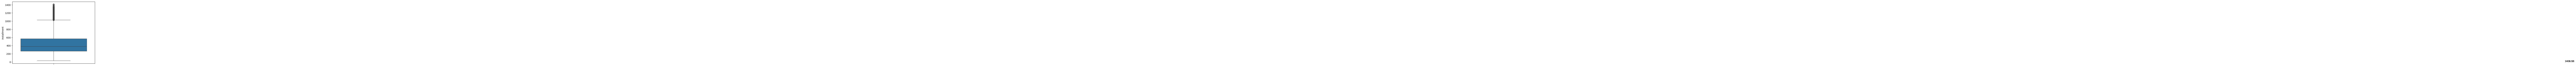

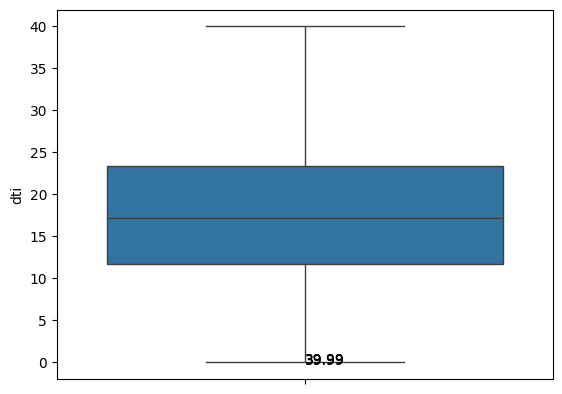

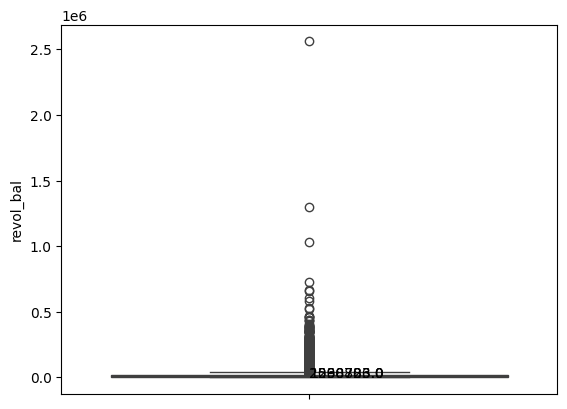

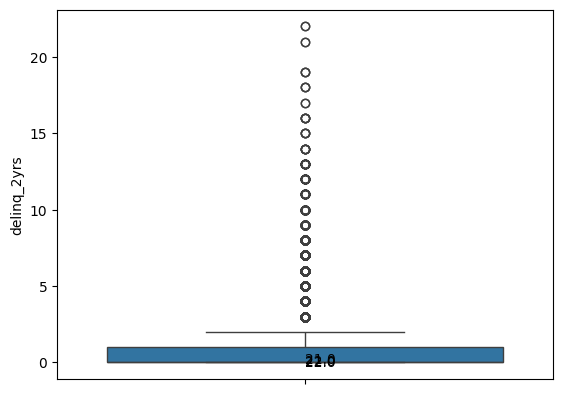

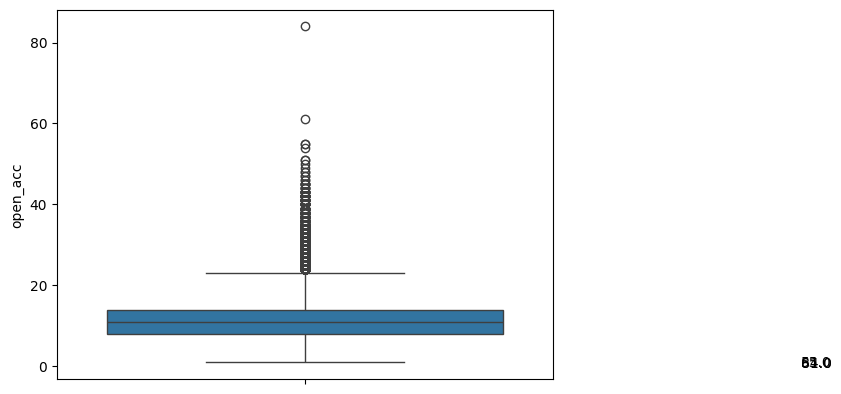

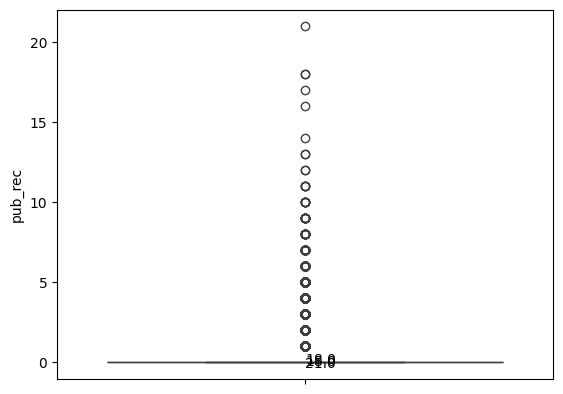

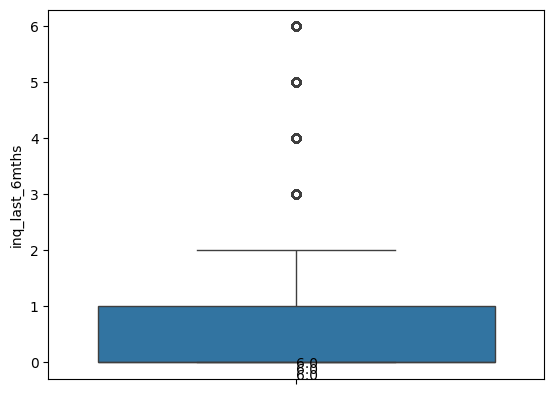

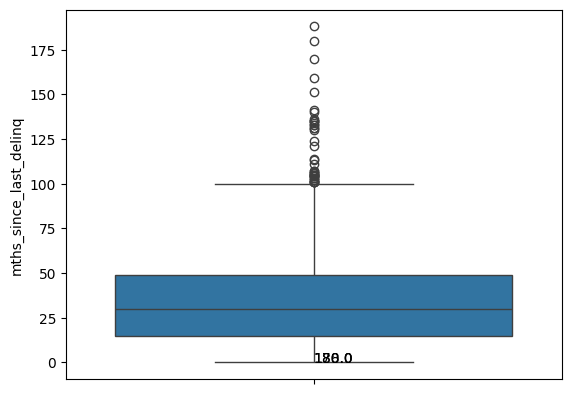

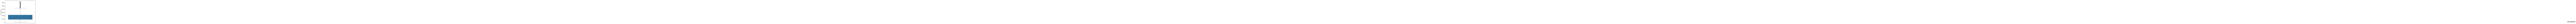

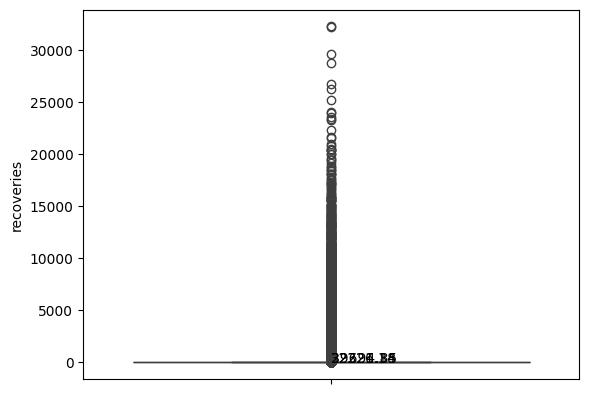

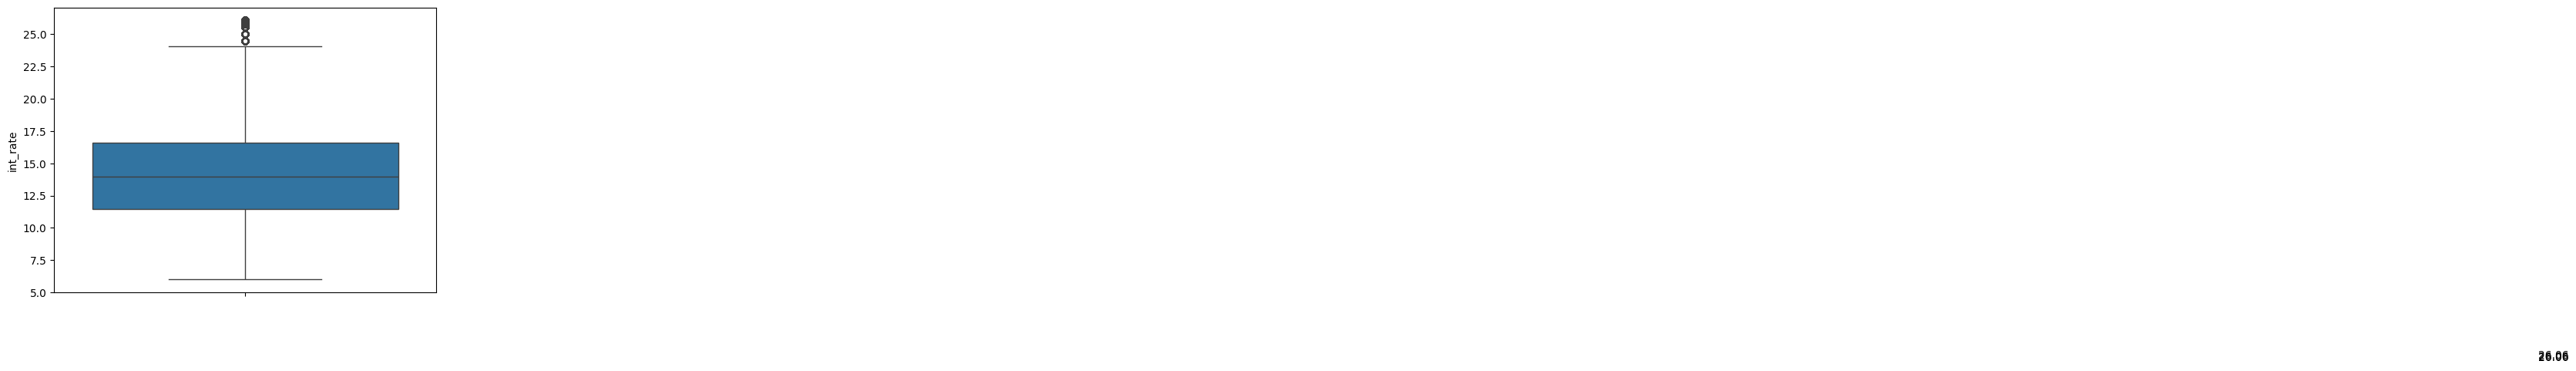

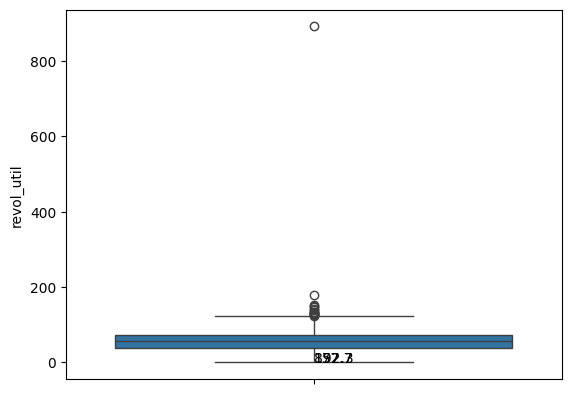

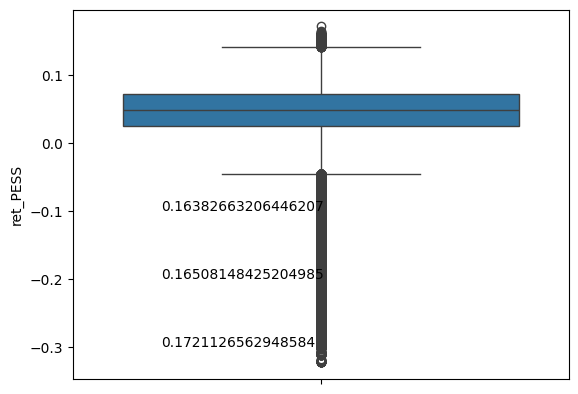

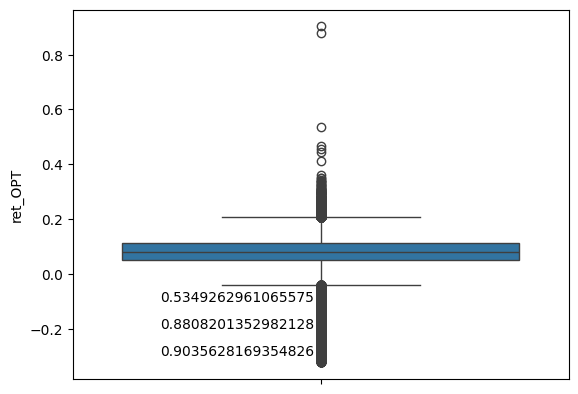

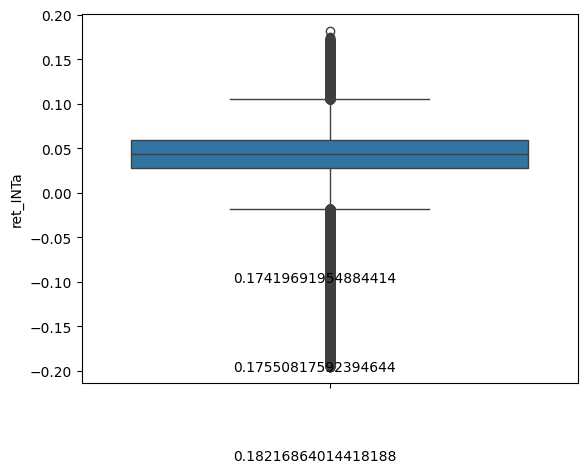

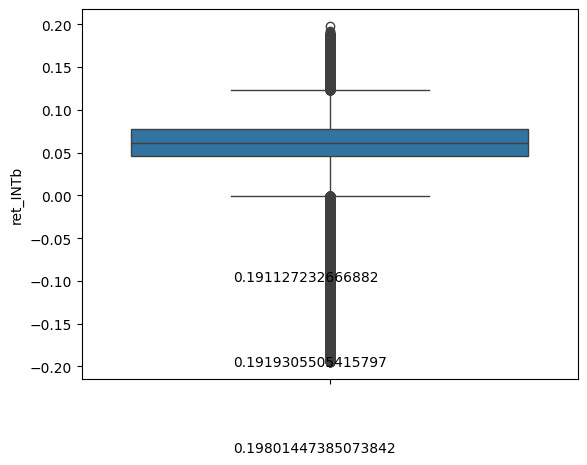

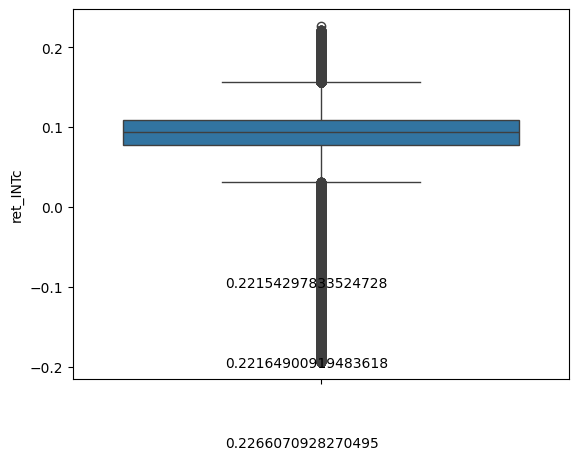

term
2 distinct values
term
36 months    82925
60 months    36662
Name: count, dtype: int64


grade
7 distinct values
grade
C    35204
B    32063
D    23152
A    13965
E    10986
F     3295
G      922
Name: count, dtype: int64


emp_length
12 distinct values
emp_length
10+ years    43441
2 years       9915
3 years       9038
< 1 year      8392
1 year        6947
4 years       6637
5 years       6434
7 years       6408
6 years       5846
8 years       5823
9 years       4690
Name: count, dtype: int64


home_ownership
4 distinct values
home_ownership
MORTGAGE    64138
RENT        43890
OWN         11558
ANY             1
Name: count, dtype: int64


verification_status
3 distinct values
verification_status
Source Verified    49933
Not Verified       36454
Verified           33200
Name: count, dtype: int64


loan_status
2 distinct values
loan_status
Fully Paid     97950
Charged Off    21637
Name: count, dtype: int64


purpose
13 distinct values
purpose
debt_consolidation    73827
credit_ca

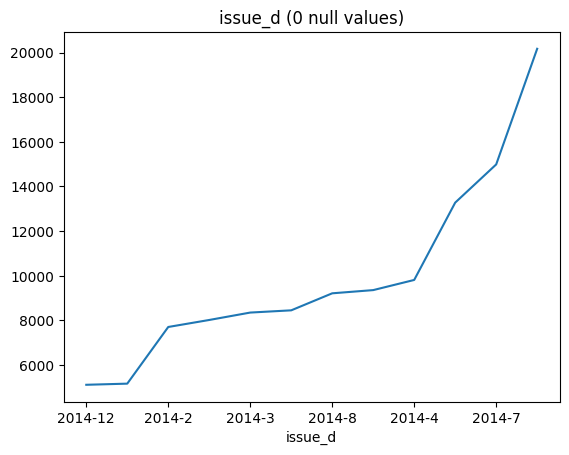

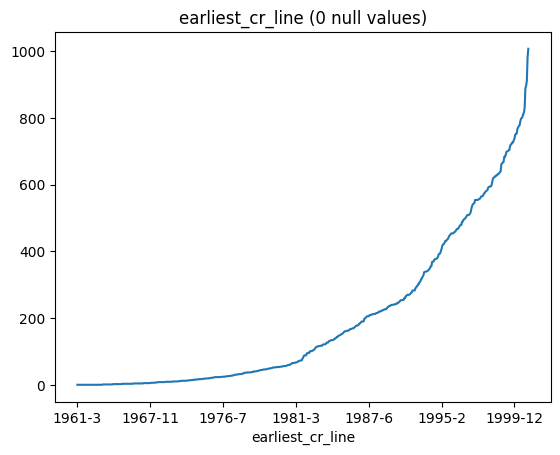

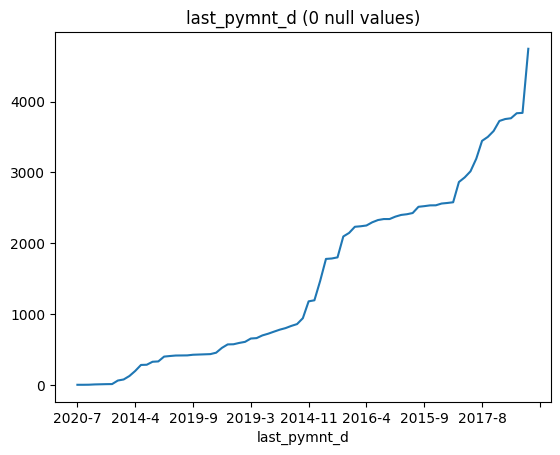

In [ ]:
visualize_columns()

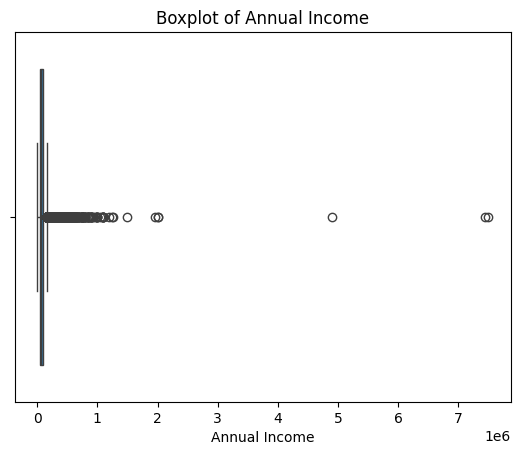

In [ ]:
#annual income boxplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=final_data['annual_inc'])
plt.title('Boxplot of Annual Income')
plt.xlabel('Annual Income')
plt.show()




*   Annual income has some outliers which might cause unnecessary noise in our prediction
*   We take a number slight higher than outlier threshold and filter them out



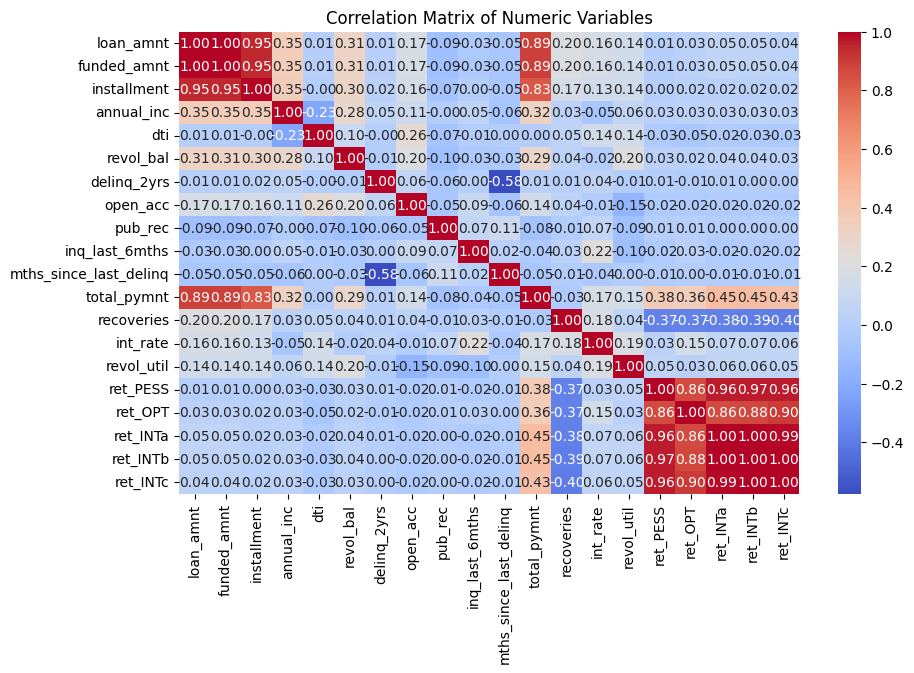

In [ ]:
#bivariate analysis
import seaborn as sns
numeric_cols = float_cols + perc_cols + ret_cols
corr = final_data[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Variables")
plt.show()




*   High correlation between attributes like loan_amnt and funded_amnt means we can drop one in clustering to reduce redundancy
*   loan_amnt and installment are also strong correlated
*   variables with no correlation to other variables are great candidates for clustering







In [ ]:
#removing outliers
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 200000] #taken a higher value than ideal threshold
final_data = final_data[final_data.revol_util < 190] #taken a higher value than ideal threshold
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 2971 rows


In [ ]:
# Remove all loans that are too recent to have been paid off or defaulted
n_rows = len(final_data)
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


Initial hypotheses about feature importance:


1.   Higher loan_amnt-> Higher risk
2.   Higher installment-> Higher risk
3.   Lower sub_grade-> Higher risk
4.   Higher inq_last_6mths-> Higher risk
5.   Lower mths_since_last_delinq-> Higher risk



## Understanding Loan Grades

In [ ]:
# Find the percentage of loans by grade, the default by grade, and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)*100 )
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)*100 )
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)*100 )
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)*100 )
ret_by_grade_INTc = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTc)*100 )
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate))

combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb
combined['return_INTc'] = ret_by_grade_INTc

combined

<ipython-input-58-4c16d05dbe64>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
<ipython-input-58-4c16d05dbe64>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)*100 )
<ipython-input-58-4c16d05dbe64>:5: Deprecati

count    default   int_rate  return_OPT  return_PESS  return_INTa  \
grade                                                                          
A      11.525005   5.997024   7.619062    4.075215     2.500030     2.535952   
B      26.834225  11.191001  11.239159    5.717740     3.230771     3.107602   
C      29.502813  18.174684  14.156743    6.586548     3.345360     3.467570   
D      19.406428  24.797844  17.117745    7.451089     3.368995     3.736111   
E       9.202854  32.584793  20.355143    8.056066     3.156786     3.699044   
F       2.762914  36.654252  24.249156    9.337055     3.346298     3.909041   
G       0.765761  42.553191  25.855913    9.124139     2.402225     3.315439   

       return_INTb  return_INTc  
grade                            
A         4.153118     7.116957  
B         4.758493     7.784771  
C         5.101082     8.093606  
D         5.359438     8.332221  
E         5.310587     8.262068  
F         5.549342     8.555183  
G         4.912699     7.841035

In [ ]:
 #Remove the total_pymnt from the list of continuous features; this variable is highly predictive of the outcome but is not known at the time the loan is issued
continuous_features = float_cols

continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]

In [ ]:
#pickle file
data_dir = os.path.join("..", "data")
os.makedirs(data_dir, exist_ok=True)
pickle_file = os.path.join(data_dir, "clean_data_loan.pickle")
final_data.to_pickle(pickle_file)
print(f"Saved cleaned data to: {pickle_file}")


Saved cleaned data to: ../data/clean_data_loan.pickle


In [ ]:
final_data.to_pickle('/content/drive/MyDrive/Business Analytics/clean_data_loan_2014.pickle')

In [ ]:
final_data.to_csv('/content/drive/MyDrive/Business Analytics/clean_data_loan_2014.csv', index=False)

## Cluster Analysis

In [ ]:
# Create an ordinal mapping for sub_grade(since we cant take categorical variables)
subgrade_order = sorted(final_data['sub_grade'].unique())  # e.g., ['A1', 'A2', ..., 'G5']
subgrade_map = {sg: i for i, sg in enumerate(subgrade_order)}
final_data['sub_grade_num'] = final_data['sub_grade'].map(subgrade_map)


In [ ]:
cluster_vars = [
    'loan_amnt', 'annual_inc', 'int_rate', 'sub_grade_num',
    'dti', 'revol_util', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'inq_last_6mths','mths_since_last_delinq']

In [ ]:
cluster_data = final_data[cluster_vars].copy()


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

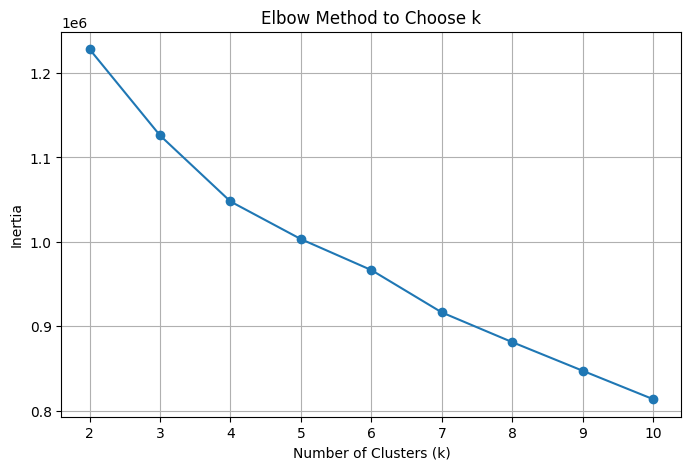

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method to Choose k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [ ]:
optimal_k = 4  # adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(cluster_data_scaled)

# Add cluster labels to your original DataFrame
final_data['cluster'] = cluster_labels

In [ ]:
pd.crosstab(final_data['cluster'], final_data['grade'])

grade       A      B      C      D     E     F    G
cluster                                            
0        3632  10325  10956   3644   357    20    3
1           0     12   2267  12431  9124  3082  871
2        7456  15928  13999   2117    16     0    0
3        2352   5028   7183   4439  1235   120   19

In [ ]:
final_data.groupby('cluster')[cluster_vars].mean()


loan_amnt     annual_inc   int_rate  sub_grade_num        dti  \
cluster                                                                     
0        11566.090991   67137.528473  12.683201       9.732799  17.280226   
1        14816.022780   62298.152132  19.234604      19.797963  20.558886   
2        10792.308179   62596.950928  11.797866       8.380782  16.442525   
3        24660.338143  113383.066973  13.768304      11.459658  18.066514   

         revol_util  delinq_2yrs   open_acc   pub_rec     revol_bal  \
cluster                                                               
0         50.948384     1.841172  11.687252  0.160452  10417.206898   
1         60.766351     0.443913  11.572606  0.300608  11805.728866   
2         50.243327     0.008174  10.695971  0.329790   9574.662542   
3         63.838977     0.556439  14.624460  0.090204  31361.159501   

         inq_last_6mths  mths_since_last_delinq  
cluster                                          
0              0.642534               12.025642  
1              1.287437               35.378450  
2              0.633718               49.108513  
3              0.660925               31.287397

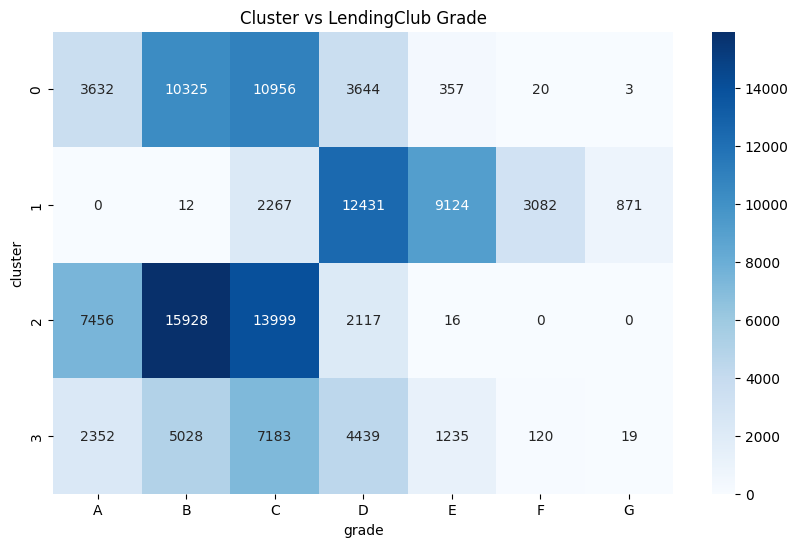

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Cross-tab: Cluster vs LendingClub Grade
ct = pd.crosstab(final_data['cluster'], final_data['grade'])

# Plot with integer values (not scientific)
plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')  # fmt='d' = display integers
plt.title("Cluster vs LendingClub Grade")
plt.xlabel("grade")
plt.ylabel("cluster")
plt.show()


This heatmap shows a cross-tabulation between cluster membership and LendingClub loan grades, revealing how closely the clustering aligns with LendingClub's internal risk classifications.

Overall, the clustering structure shows a strong alignment with LendingClub's risk-based grading, especially visible in Cluster 1 and Cluster 2, which are quite distinct in grade distribution. This confirms that the clustering is effectively segmenting borrowers by credit risk.

In [ ]:
#using Cramér’s V to check association between two variables
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Run it on your cross-tab
crosstab = pd.crosstab(final_data['cluster'], final_data['grade'])
cramers_v(crosstab)


np.float64(0.44799257606032455)

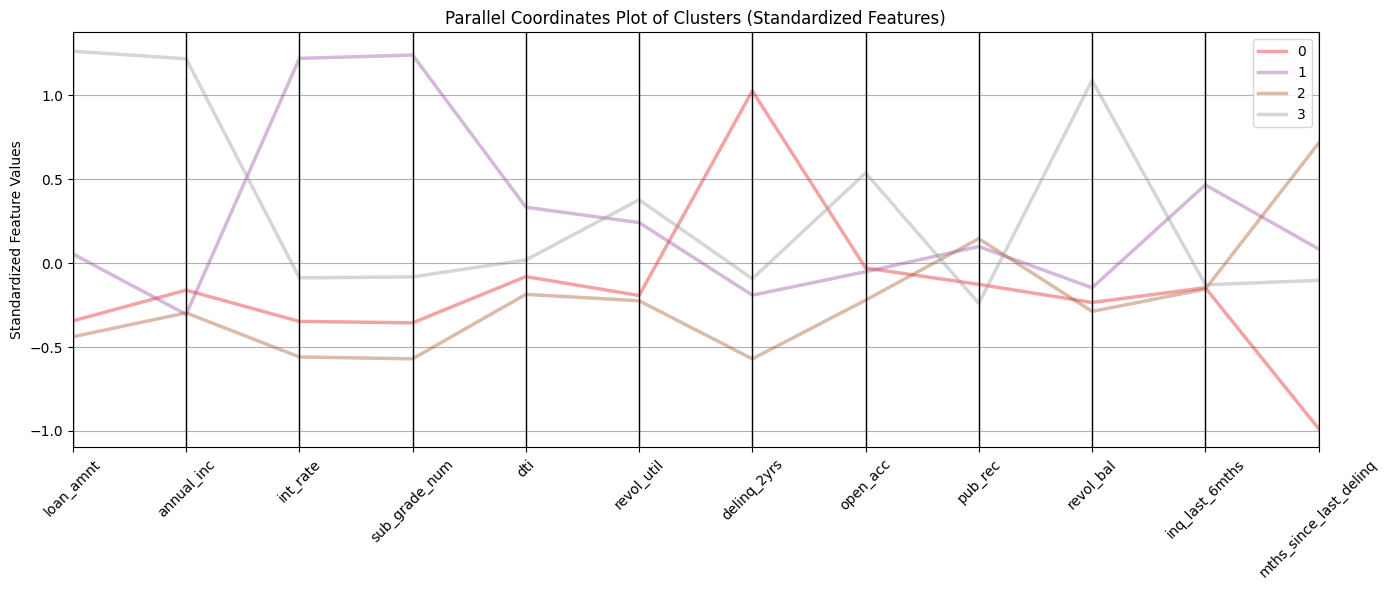

In [ ]:
from sklearn.preprocessing import StandardScaler
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import numpy as np

# Select only the numeric features and cluster label
cluster_vars = [
    'loan_amnt', 'annual_inc', 'int_rate', 'sub_grade_num',
    'dti', 'revol_util', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'inq_last_6mths','mths_since_last_delinq']
plot_data = final_data[cluster_vars + ['cluster']].dropna().copy()

# Standardize the feature values
scaler = StandardScaler()
plot_data[cluster_vars] = scaler.fit_transform(plot_data[cluster_vars])

centroids = plot_data.groupby('cluster').mean().reset_index()
centroids['cluster'] = centroids['cluster'].astype(str)  # For coloring

# Sample the data if it's large
plot_sample = plot_data.sample(3000, random_state=42)

# Plot
plt.figure(figsize=(14, 6))
parallel_coordinates(centroids, 'cluster', colormap='Set1', alpha=0.4, linewidth=2.5)
plt.title("Parallel Coordinates Plot of Clusters (Standardized Features)")
plt.xticks(rotation=45)
plt.ylabel("Standardized Feature Values")
plt.grid(True)
plt.tight_layout()
plt.show()


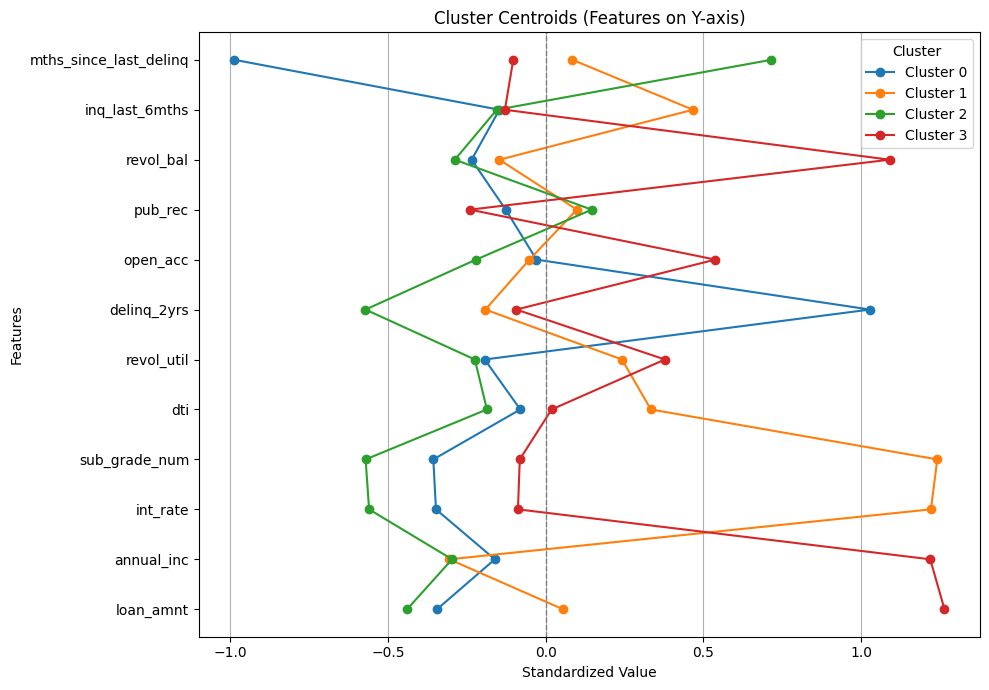

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose centroids
centroids_T = centroids.set_index('cluster').T

# Set up the plot
plt.figure(figsize=(10, 7))

clusters = centroids_T.columns
features = centroids_T.index

for cluster in clusters:
    plt.plot(centroids_T[cluster], features, marker='o', label=f'Cluster {cluster}')

# Styling
plt.title("Cluster Centroids (Features on Y-axis)")
plt.xlabel("Standardized Value")
plt.ylabel("Features")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True, axis='x')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()



Interpretation of clusters-

Cluster 0(Blue Line): Low-Risk, Small Loan Borrowers
This group has low loan amounts, low interest rates, and long clean credit histories. Their debt-to-income and credit utilization are also low. They align closely with Grades A and B.

Cluster 1(Yellow Line): Affluent, Prime Large Borrowers
Cluster 1 includes high-income borrowers with large loans but low DTI and utilization. They receive moderate interest rates and are financially stable. Likely mapped to Grades B and C.

Cluster 2(Green Line): Credit-Stretched, Moderate Risk
Borrowers in this cluster show higher DTI, credit usage, and delinquencies. Despite lower income and fewer accounts, they have lower-than-expected rates. They resemble Grades C and D.

Cluster 3(Red Line): High-Risk, Subprime Borrowers
These borrowers have high interest rates, poor credit history, high utilization, and frequent inquiries. They take smaller loans with low income and are aligned with Grades E–G.




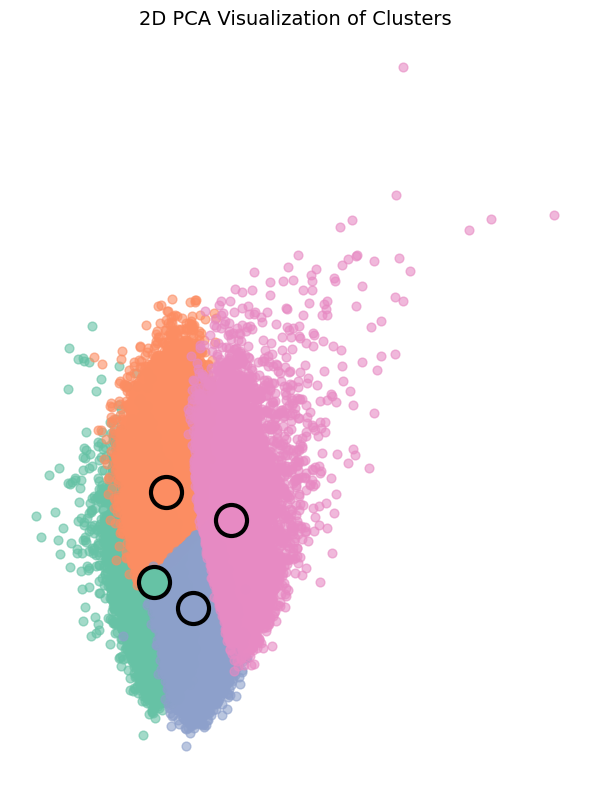

In [ ]:
#2D plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Prepare your features (already standardized) ---
X = plot_data  # Use your final scaled clustering features
labels = final_data['cluster'].values

# --- Step 2: Reduce to 2D using PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# --- Step 3: Calculate cluster centroids in PCA space ---
n_clusters = len(np.unique(labels))
centroids = np.array([X_pca[labels == k].mean(axis=0) for k in range(n_clusters)])

# --- Step 4: Plot ---
plt.figure(figsize=(6, 8))
palette = sns.color_palette("Set2", n_clusters)

# Plot points
for k in range(n_clusters):
    cluster_points = X_pca[labels == k]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                color=palette[k], alpha=0.6, s=40)

# Plot centroids
for i, center in enumerate(centroids):
    plt.scatter(center[0], center[1],
                s=500, color=palette[i], edgecolors='black', linewidth=3)

plt.xticks([])
plt.yticks([])
plt.box(False)
plt.title("2D PCA Visualization of Clusters", fontsize=14)
plt.tight_layout()
plt.show()


This 2D PCA plot provides a visual representation of the clusters formed from the borrower data, reducing high-dimensional features into two principal components. Each color represents a distinct cluster, while the black-circled points indicate the centroids of those clusters. The clusters are fairly well-separated, suggesting meaningful differentiation among borrower profiles. The overlap along the center reflects some similarity in borrower characteristics between adjacent groups.

### Principal Component Analysis

Using the same variables as Clustering

In [ ]:
PCA_vars = [
    'loan_amnt', 'annual_inc', 'int_rate', 'sub_grade_num',
    'dti', 'revol_util', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'inq_last_6mths','mths_since_last_delinq'
]

In [ ]:
#Standardizing or scaling data for Principal Component Analysis

scaler = StandardScaler()
PCA_data_scaled = scaler.fit_transform(final_data[PCA_vars])

In [ ]:
#Performing PCA

from sklearn.decomposition import PCA
pca = PCA()
pca_components = pca.fit_transform(PCA_data_scaled)

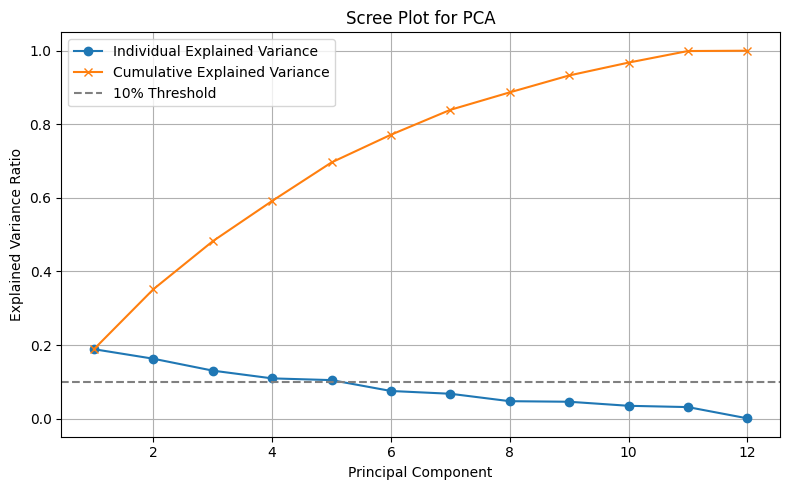

In [ ]:
#Scree Plot

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='x', label='Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.axhline(0.1, color='gray', linestyle='--', label='10% Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Interpretation:
The first 3–4 principal components explain most of the variance (~72%) in the data.
This suggests that a large portion of the variation in loan characteristics can be captured in just a few dimensions.




In [ ]:
#Loadings table for the top 4 PCs

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(cluster_vars))],
    index=cluster_vars
)
print("PCA Loadings (Top 4 Components):")
display(loadings.iloc[:, :4].round(3))

PCA Loadings (Top 4 Components):


PC1    PC2    PC3    PC4
loan_amnt               0.302  0.411 -0.183 -0.170
annual_inc              0.102  0.494 -0.114 -0.439
int_rate                0.588 -0.285  0.009 -0.089
sub_grade_num           0.589 -0.281  0.007 -0.084
dti                     0.200 -0.021 -0.027  0.707
revol_util              0.249  0.109 -0.163  0.120
delinq_2yrs             0.099  0.152  0.667 -0.032
open_acc                0.115  0.268  0.011  0.311
pub_rec                -0.024 -0.223 -0.090 -0.274
revol_bal               0.194  0.460 -0.206  0.153
inq_last_6mths          0.176 -0.144  0.027 -0.228
mths_since_last_delinq -0.106 -0.195 -0.655  0.016

Interpretation:

PC1 is mostly influenced by sub_grade_num and int_rate, it captures credit grade and interest rate, effectively representing borrower creditworthiness.

PC2 has high negative loadings for dti and int_rate — it reflects borrower risk or debt burden.

PC3 is driven by open_acc (positive) and revol_util (negative) — indicating account diversity.

PC4 is defined by pub_rec and delinq_2yrs — associated with creditworthiness issues.

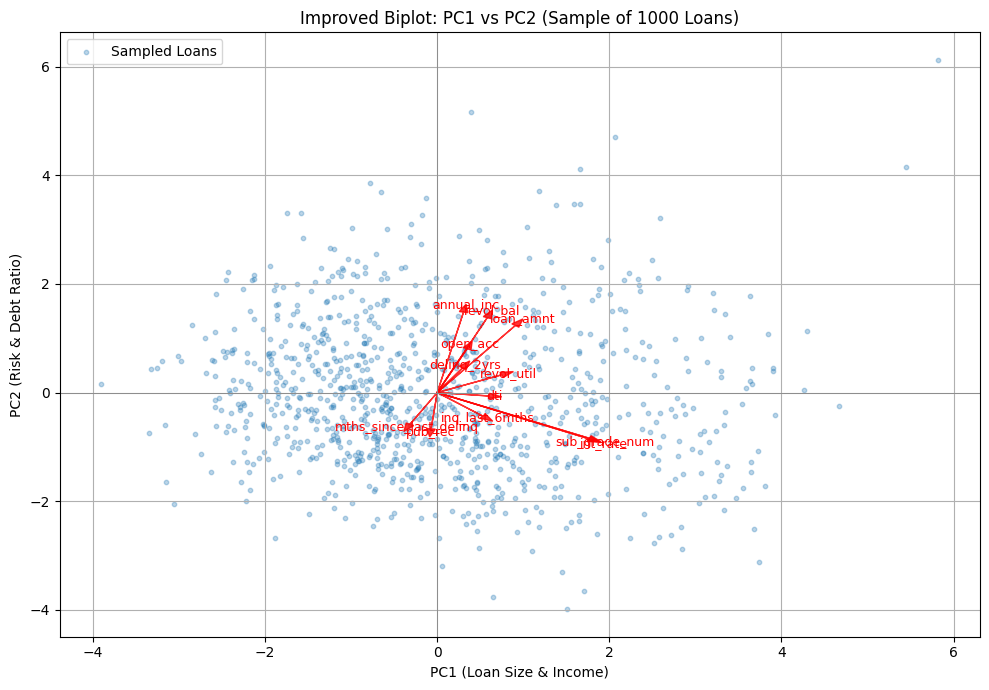

In [ ]:
#Biplot (1000 randomly selected data points)

sample_indices = np.random.choice(pca_components.shape[0], size=1000, replace=False)
sampled_components = pca_components[sample_indices]

plt.figure(figsize=(10, 7))
plt.scatter(sampled_components[:, 0], sampled_components[:, 1], alpha=0.3, label="Sampled Loans", s=10)

for i, feature in enumerate(cluster_vars):
    plt.arrow(0, 0, 3 * pca.components_[0, i], 3 * pca.components_[1, i],
              color='r', alpha=0.8, head_width=0.1)
    plt.text(3.3 * pca.components_[0, i], 3.3 * pca.components_[1, i],
             feature, color='r', ha='center', va='center', fontsize=9)

plt.xlabel('PC1 (Loan Size & Income)')
plt.ylabel('PC2 (Risk & Debt Ratio)')
plt.title('Improved Biplot: PC1 vs PC2 (Sample of 1000 Loans)')
plt.grid(True)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.tight_layout()
plt.legend()
plt.show()

Interpretation:

- The biplot shows how loans differ along the first two principal components.

- Arrows indicate how original features contribute to PC1 and PC2.

- Borrowers on the right side tend to have lower credit grades and higher interest rates.

- Borrowers higher on the plot tend to have larger loans and higher income, indicating greater financial scale.

- The red arrows show which features contribute most to each direction. Arrows pointing strongly along an axis indicate strong influence on that component.

- Sampling 1,000 loans keeps the plot readable and helps highlight general borrower trends without clutter.

## PCA and Grade - How does Loan Grade relate to the structure of the data in PCA space

In [ ]:
#Running PCA on individual subsets - Comparing Grade A and Grade G

#Grade A
grade_a_data = final_data[final_data['grade'] == 'A'][cluster_vars].dropna()

scaler_a = StandardScaler()
grade_a_scaled = scaler_a.fit_transform(grade_a_data)

#PCA on Grade A
pca_a = PCA()
pca_a_components = pca_a.fit_transform(grade_a_scaled)

loadings_a = pd.DataFrame(
    pca_a.components_.T,
    columns=[f'PC{i+1}' for i in range(len(cluster_vars))],
    index=cluster_vars
)

print("Grade A PCA Loadings (Top 3 PCs):")
display(loadings_a.iloc[:, :3].round(3))

#Grade G
grade_g_data = final_data[final_data['grade'] == 'G'][cluster_vars].dropna()

scaler_g = StandardScaler()
grade_g_scaled = scaler_g.fit_transform(grade_g_data)

#PCA on Grade G
pca_g = PCA()
pca_g_components = pca_g.fit_transform(grade_g_scaled)

loadings_g = pd.DataFrame(
    pca_g.components_.T,
    columns=[f'PC{i+1}' for i in range(len(cluster_vars))],
    index=cluster_vars
)

print("Grade G PCA Loadings (Top 3 PCs):")
display(loadings_g.iloc[:, :3].round(3))

Grade A PCA Loadings (Top 3 PCs):


PC1    PC2    PC3
loan_amnt              -0.186  0.483 -0.206
annual_inc             -0.257  0.428 -0.111
int_rate                0.634  0.213 -0.091
sub_grade_num           0.638  0.213 -0.085
dti                     0.036  0.105 -0.047
revol_util              0.115  0.289 -0.217
delinq_2yrs             0.051  0.232  0.648
open_acc               -0.173  0.193  0.095
pub_rec                 0.081 -0.142 -0.064
revol_bal              -0.186  0.466 -0.198
inq_last_6mths          0.037  0.018 -0.048
mths_since_last_delinq -0.040 -0.263 -0.637

Grade G PCA Loadings (Top 3 PCs):


PC1    PC2    PC3
loan_amnt               0.497 -0.192 -0.223
annual_inc              0.477 -0.294 -0.293
int_rate                0.022 -0.078 -0.079
sub_grade_num           0.138 -0.175 -0.176
dti                     0.116  0.521  0.258
revol_util              0.228  0.367  0.152
delinq_2yrs             0.115 -0.359  0.567
open_acc                0.329  0.300 -0.004
pub_rec                -0.181 -0.063 -0.230
revol_bal               0.475  0.279  0.046
inq_last_6mths          0.140 -0.097 -0.205
mths_since_last_delinq -0.201  0.351 -0.565

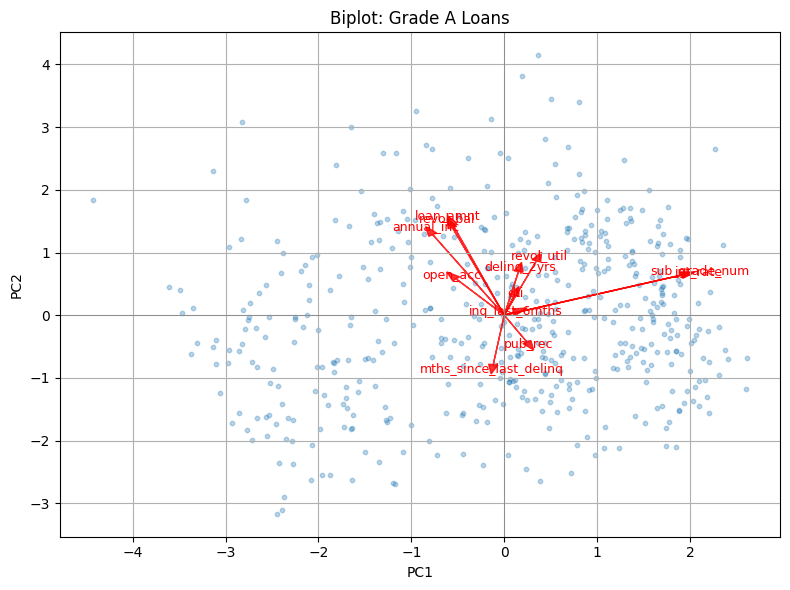

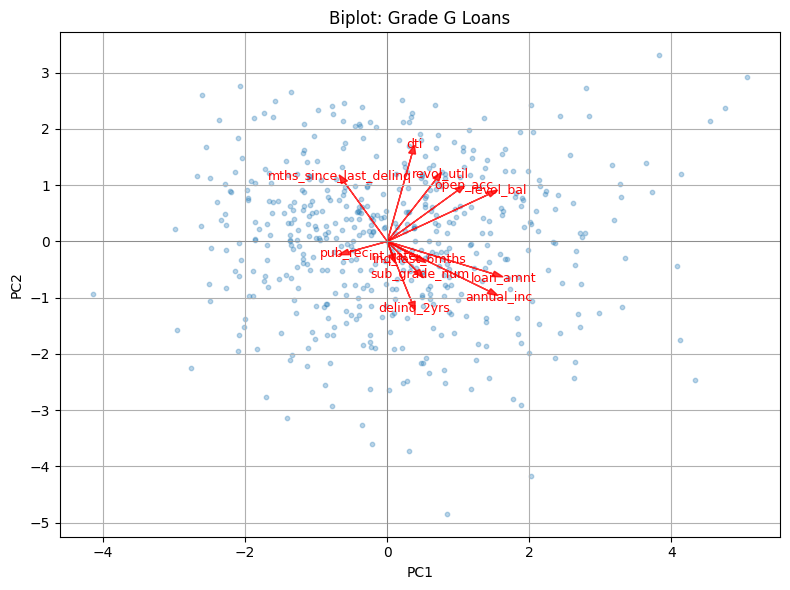

In [ ]:
#Biplots for both - Sample of 500 data points

def plot_biplot(pca_components, pca_model, feature_names, title, sample_size=500):
    # Sample a subset of loans for clarity
    indices = np.random.choice(pca_components.shape[0], size=min(sample_size, len(pca_components)), replace=False)
    sample = pca_components[indices]

    plt.figure(figsize=(8, 6))
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.3, s=10)

    # Plot feature arrows (loadings)
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, 3 * pca_model.components_[0, i], 3 * pca_model.components_[1, i],
                  color='red', alpha=0.8, head_width=0.1)
        plt.text(3.3 * pca_model.components_[0, i], 3.3 * pca_model.components_[1, i],
                 feature, color='red', fontsize=9, ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Biplot: {title}")
    plt.grid(True)
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.tight_layout()
    plt.show()

#Biplot for Grade A
plot_biplot(
    pca_components=pca_a_components,
    pca_model=pca_a,
    feature_names=cluster_vars,
    title="Grade A Loans"
)

#Biplot for Grade G
plot_biplot(
    pca_components=pca_g_components,
    pca_model=pca_g,
    feature_names=cluster_vars,
    title="Grade G Loans"
)

Interpretation of Grade A and Grade G Biplots

- In both grades, PC1 is driven by loan amount, installment, and income, reflecting financial scale.
- In Grade A:
  - PC2 emphasizes open accounts and DTI, with little role from risk features.
  - Borrowers are more separated by financial diversity than risk.
- In Grade G:
  - PC2 shows stronger loadings for DTI, revol_util, and revol_bal, indicating that credit stress and debt burden are more prominent.
  - Risk-related features become more influential as grade decreases.

This supports the idea that risk structure changes across credit grades, and PCA helps reveal those underlying patterns.
